<a href="https://colab.research.google.com/github/vlr-memory-allocation/3d_to_2d/blob/main/PyTorch3D_camera_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#@title Install dependencies.
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
#@title Download data to the `./obj/` directory.
!wget -O cat_3d_model.zip https://raw.githubusercontent.com/vlr-memory-allocation/3d_to_2d/main/data/zipped/cat_3d_model.zip 
%mkdir obj
%cd obj
!unzip ../cat_3d_model.zip -d obj && rm ../cat_3d_model.zip
!ls obj

In [79]:
#@title Required imports.
# Base import group.
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm

# Obj loading and visualization group.
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# Camera and rasterization group.
from pytorch3d.renderer import FoVPerspectiveCameras, RasterizationSettings
from pytorch3d.renderer import MeshRenderer, MeshRasterizer, SoftPhongShader

# Lights group.
from pytorch3d.renderer import DirectionalLights

In [18]:
#@title Set the device.
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    print('WARNING: CPU only, this will be slow! '
          'Change runtime type: Runtime ->  Change runtime type -> '
          'Hardware accelerator: GPU ')

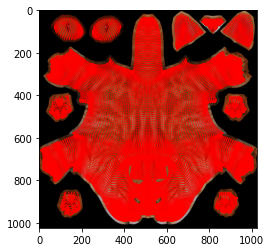

In [13]:
#@title Load obj file and visualize UV map with used pixels.
obj_path = r'obj/cat.obj'
obj_mesh = load_objs_as_meshes([obj_path], device=device)
texturesuv_image_matplotlib(obj_mesh.textures, subsample=None)

In [57]:
from typing import Callable 
import torch


class AxesBasedRotation:
    """Class for axes based rotation parameters optimization."""

    def __init__(self, angles: torch.Tensor, measure_units: str = 'degree'):
        """
        Create instance of rotation notation based on axes around angles.

        Parameters
        ----------
        angles: np.ndarray
            Angles in AxesBased notation.
        """
        if measure_units not in ('degree', 'radian'):
            raise IOError(
                'Unexpected `measure_units` value. '
                'Should be in (`degree`, `radian`)')
        if measure_units == 'degree':
            angles = [ang * np.pi / 180.0 for ang in angles]
        self.measure_units = measure_units

        if len(angles) != 3:
            raise RuntimeError('Wrong amount of angles: {}'.format(
                len(angles)))
        self.around_Ox = nn.Parameter(angles[0], requires_grad=True)
        self.around_Oy = nn.Parameter(angles[1], requires_grad=True)
        self.around_Oz = nn.Parameter(angles[2], requires_grad=True)

    def get_rot_mat(self):
        """
        Calculate rotation matrix based on axes around angles.

        The matrix is sensitive to the rotation around axes order.
        Fixed rotation order: around Ox -> around Oy -> around Oz.

        Returns
        -------
        torch.Tensor: 3x3 rotation matrix for axes around angles notation.
        """
        angles = [self.around_Ox, self.around_Oy, self.around_Oz]
        cos_Ox, cos_Oy, cos_Oz = [torch.cos(a) for a in angles]
        sin_Ox, sin_Oy, sin_Oz = [torch.sin(a) for a in angles]

        one = torch.autograd.Variable(torch.ones(1))
        zero = torch.autograd.Variable(torch.zeros(1))

        Rx = torch.cat((one, zero, zero,
                        zero, cos_Ox.view(1), -sin_Ox.view(1),
                        zero, sin_Ox.view(1), cos_Ox.view(1))).view(1, 3, 3)

        Ry = torch.cat((cos_Oy.view(1), zero, sin_Oy.view(1),
                        zero, one, zero,
                        -sin_Oy.view(1), zero, cos_Oy.view(1))).view(1, 3, 3)

        Rz = torch.cat((cos_Oz.view(1), -sin_Oz.view(1), zero,
                        sin_Oz.view(1), cos_Oz.view(1), zero,
                        zero, zero, one)).view(1, 3, 3)
        return torch.bmm(Rz, torch.bmm(Ry, Rx))[0]

    def get_parameters(self):
        """Get torch.nn.Parameters."""
        params = []
        for attr in dir(self):
            attr_inst = self.__getattribute__(attr)
            if isinstance(attr_inst, torch.nn.Parameter):
                params.append(attr_inst)
        return params


class DiffRenderingModel(nn.Module):
    """Model with optimized camera position parameters."""
    def __init__(self, meshes: meshes.Meshes,
                 render_scene_f: Callable,
                 gt_image: torch.Tensor,
                 r_init: torch.Tensor,
                 t_init: torch.Tensor):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.render_scene_f = render_scene_f

        gt_image = gt_image.to(self.device)
        self.register_buffer('gt_image', gt_image)

        self.rotation = AxesBasedRotation(r_init)
        self.translation = torch.nn.Parameter(t_init)

    def forward(self):
        """Render image based on mesh and camera position."""
        rendered_image = self.render_scene_f(self.meshes,
                                             rotation=self.rotation,
                                             translation=self.translation,
                                             device=self.device)[0]
        loss = torch.sum((rendered_image - self.gt_image) ** 2)
        return loss, rendered_image


def build_camera_matrices(rot: AxesBasedRotation,
                          t: nn.Parameter,
                          device: torch.device):
    """Build rotation and translation matrices."""
    rot_mat = rot.get_rot_mat().type(torch.DoubleTensor)[None, :].to(device)
    t_mat = t.type(torch.DoubleTensor)[None, :].to(device)
    return rot_mat, t_mat


def build_scene_images(obj_mesh: meshes.Meshes, 
                       fov: float,
                       image_size: int,
                       rotation: AxesBasedRotation, 
                       translation: nn.Parameter, 
                       lights: DirectionalLights,
                       device: torch.device):
    world_to_cam_rot, relative_t = build_camera_matrices(rotation, 
                                                         translation,
                                                         device)
    cameras = FoVPerspectiveCameras(device=device, R=world_to_cam_rot,
                                    T=relative_t, fov=fov)
    rasterization_settings = RasterizationSettings(image_size=image_size)
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=rasterization_settings
        ),
        shader=SoftPhongShader(cameras=cameras,
                               device=device,
                               lights=lights)
    )
    images = renderer(obj_mesh)
    return images

In [80]:
#@title Camera parameters fit method.
def fit(diff_rend_model: DiffRenderingModel,
        iterations: int,
        loss_eps: float,
        data_save_step: int = 0,
        r_lr: float = 0.005,
        t_lr: float = 0.01):
  
    t_opt = torch.optim.Adam(model.parameters(), lr=t_lr)
    r_opt = torch.optim.Adam(model.rotation.get_parameters(), lr=r_lr)
    optimizers = [t_opt, r_opt]

    optimization_interim = {}
    loss_val = []
    for iter in tqdm(range(iterations + 1)):
        iter_meta = {}

        list(map(lambda x: x.zero_grad(), optimizers))
        loss, rendered_img = diff_rend_model()
        loss.backward(retain_graph=True)
        list(map(lambda x: x.step(), optimizers))

        iter_meta['loss'] = loss.item()
        loss_val.append(loss.data.cpu().numpy())

        if data_save_step > 0 and iter % data_save_step == 0:
            plt.figure()
            plt.axis('off')
            plt.imshow(rendered_img.detach().cpu().numpy()[..., :3])
            print(f'Loss at iter {iter}: ', loss.item())
            iter_meta['image'] = rendered_img

        optimization_interim.update({iter: iter_meta})

        if loss.item() < loss_eps or torch.isnan(loss):
            break

    final_cam_position = [model.rotation, model.translation]
    return final_cam_position, optimization_interim

In [59]:
#@title Set intrinsics, light and set context for `build_scene_image` function.
fov = 60.0
image_size = 256
light_position=[[0.0, -5.0, -5.0]]
lights = DirectionalLights(device=device,
                           ambient_color=((1., 1., 1.),),
                           diffuse_color=((0., 0., 0.),),
                           specular_color=((0., 0., 0.),),
                           direction=light_position)
render_scene_f = partial(build_scene_images,
                         fov=fov,
                         image_size=image_size,
                         lights=lights)

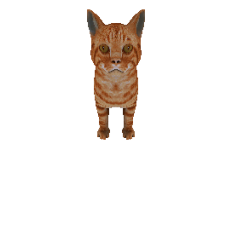

In [77]:
#@title Build Ground Truth camera parameters and show rendered image.
r_gt = AxesBasedRotation(torch.Tensor([130, 0, 180]))
t_gt = torch.Tensor([0, 0, 70])

gt_image = render_scene_f(obj_mesh=obj_mesh, 
                          rotation=r_gt, 
                          translation=t_gt, 
                          device=device)
plt.figure('GT')
plt.axis(False)
plt.imshow(gt_image.detach().cpu().numpy()[0, ..., :3])

  0%|          | 7/3001 [00:00<01:44, 28.71it/s]

Loss at iter 0:  19435.26171875


 10%|█         | 309/3001 [00:07<01:05, 40.98it/s]

Loss at iter 300:  11712.25390625


 20%|██        | 609/3001 [00:14<00:58, 40.76it/s]

Loss at iter 600:  10116.9326171875


 30%|███       | 909/3001 [00:21<00:49, 42.39it/s]

Loss at iter 900:  11497.083984375


 40%|████      | 1209/3001 [00:28<00:42, 41.88it/s]

Loss at iter 1200:  14910.46484375


 50%|█████     | 1510/3001 [00:34<00:32, 45.26it/s]

Loss at iter 1500:  16827.896484375


 60%|██████    | 1810/3001 [00:41<00:25, 46.43it/s]

Loss at iter 1800:  17357.2578125


 70%|███████   | 2108/3001 [00:47<00:19, 46.27it/s]

Loss at iter 2100:  17734.74609375


 80%|████████  | 2407/3001 [00:53<00:12, 47.22it/s]

Loss at iter 2400:  16225.70703125


 90%|█████████ | 2707/3001 [00:59<00:06, 48.55it/s]

Loss at iter 2700:  18505.345703125


100%|██████████| 3001/3001 [01:05<00:00, 45.50it/s]


Loss at iter 3000:  18584.3359375


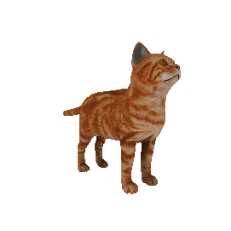

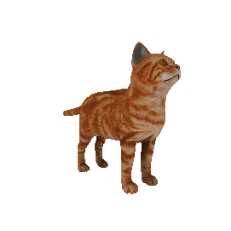

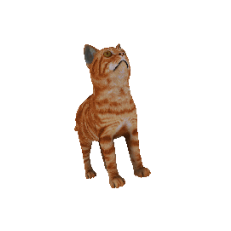

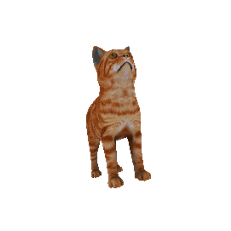

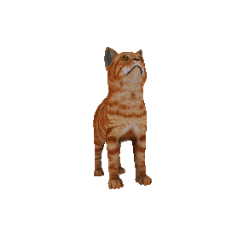

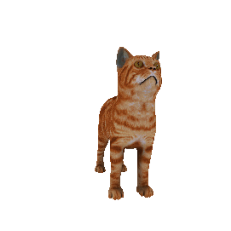

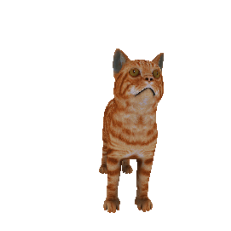

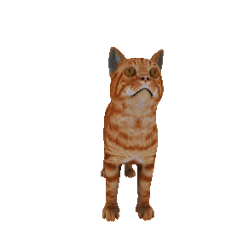

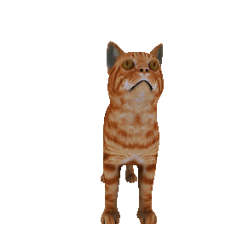

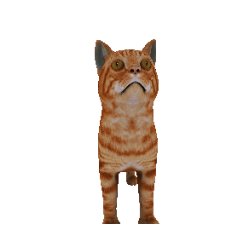

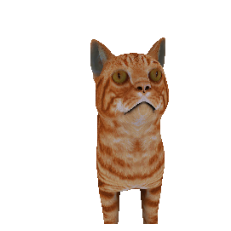

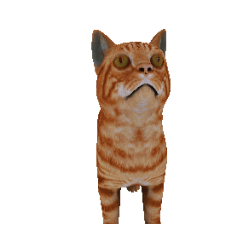

In [81]:
#@title Build init camera parameters, initialize model and start fitting.
r_init = torch.Tensor([90, 0, 140])
t_init = torch.Tensor([0, -20, 60])
model = DiffRenderingModel(meshes=obj_mesh, 
                           render_scene_f=render_scene_f, 
                           gt_image=gt_image, 
                           r_init=r_init,
                           t_init=t_init)
loss, rendered_img = model()
plt.figure('Init')
plt.axis(False)
plt.imshow(rendered_img.detach().cpu().numpy()[..., :3])

fit_output = fit(model, 3000, 1e-6, 300)